## Preambule

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pth
import xarray as xr
from plotly.subplots import make_subplots
from tqdm import tqdm
import plotly.graph_objects as go
from pathlib import Path

## Definitions

In [2]:
c400lins = ['DIAG-C400-lin-LimBio',
            'DIAG-C400-lin-LimCCS',
            'DIAG-C400-lin-LimNuclear',
            'DIAG-C400-lin-HighVRE',
            'DIAG-C400-lin-HighElectrification',
            'DIAG-C400-lin-HighH2',
            'DIAG-C400-lin-ResidualFossil',
            'DIAG-C400-lin-HighEff',
            "DIAG-C400-lin"]

scen_noc400 = ['DIAG-C400-lin-LimBio',
                'DIAG-C400-lin-LimCCS',
                'DIAG-C400-lin-LimNuclear',
                'DIAG-C400-lin-HighVRE',
                'DIAG-C400-lin-HighElectrification',
                'DIAG-C400-lin-HighH2',
                'DIAG-C400-lin-ResidualFossil',
                'DIAG-C400-lin-HighEff']

scenarios = ['DIAG-Base',
             'DIAG-NPI',
             'DIAG-C400-lin',
             'DIAG-C80-gr5',
             'DIAG-C0to80-gr5',
             'DIAG-NZero',
             'DIAG-C400-lin-LimBio',
             'DIAG-C400-lin-LimCCS',
             'DIAG-C400-lin-LimNuclear',
             'DIAG-C400-lin-HighVRE',
             'DIAG-C400-lin-HighElectrification',
             'DIAG-C400-lin-HighH2',
             'DIAG-C400-lin-ResidualFossil',
             'DIAG-C400-lin-HighEff']

ModelCols = ["lightskyblue", #"turquoise", #"#c0c0c0",
             "goldenrod", #"turquoise"
             #"firebrick", #"#ff00ff",
             "tomato", #"#800080",
             "forestgreen", #"#a52a2a",
             "darkgrey", #"goldenrod",
             #"magenta", #"tomato",
             "royalblue", # steelblue #"#4682b4",
             "purple",
             "palegreen"]#"#228b22"]

all_models = ['IMAGE 3.2',              # 
                'PROMETHEUS 1.2',         # 
            #'OSeMBE v1.0.0',          # country-level (sum?)
                'REMIND 2.1',             # 
                'WITCH 5.1',              # 
                'Euro-Calliope 2.0',      # Country-level (sum?)
                #'MEESA v1.1',             # 
                'TIAM-ECN 1.2',           # 
                'MESSAGEix-GLOBIOM 1.2',  # 
                'PRIMES 2022'
                ]
Models_raw = ["IMAGE", "PROMETHEUS", "REMIND-MAgPIE", "WITCH", "Sector-Coupled Euro-Calliope", "TIAM-ECN", "MESSAGE", "PRIMES"] 

## Selection

In [3]:
path_data = Path("X:/user/dekkerm/Projects/ECEMF/WP1/Data")
emisvar = "Emissions|CO2|Energy and Industrial Processes"
percred = 0.66
Models_touse = all_models
ModelCols_touse = ModelCols
Modelsraw_touse = Models_raw

## Reading

In [4]:
df_total = pd.read_csv(path_data / "EuropeanData" / (Models_touse[0] + ".csv"))
for m_i in range(1, len(Models_touse)):
    df = pd.read_csv(path_data / "EuropeanData" / (Models_touse[m_i] + ".csv"))
    df_total = pd.concat([df_total, df])
df_total = df_total.reset_index(drop=True)
df_total = df_total[['Model', 'Scenario', 'Variable', '2005', '2010', '2015', '2020', '2025', '2030', '2035', '2040', '2045', '2050', '2060', '2070', '2080', '2090', '2100']]
df = df_total.melt(id_vars=["Variable", "Scenario", "Model"], var_name="Time", value_name="Value")

# Remove residual fossil and highh2 scenarios from image? <= Not necessary anymore, I think they are
# val = np.copy(df.Value)
# val[(df.Scenario == "DIAG-C400-lin-ResidualFossil") & (df.Model == "IMAGE 3.2")] = np.nan
# val[(df.Scenario == "DIAG-C400-lin-HighH2") & (df.Model == "IMAGE 3.2")] = np.nan
# df.Value = val

## Filling procedures

In [5]:
rows = []
for t_i, t in enumerate([2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2060, 2070, 2080, 2090, 2100]):
    for s_i, s in enumerate(c400lins):
        val = np.nanmean(df[(df.Time == str(t)) & (df.Scenario == s) & (df.Variable == "GDP|PPP")].Value)
        rows.append(["GDP|PPP", s, "TIAM-ECN 1.2", t, val])
        rows.append(["GDP|PPP", s, "Euro-Calliope 2.0", t, val])

In [6]:
df_rows = pd.DataFrame(rows, columns = ["Variable", "Scenario", "Model", "Time", "Value"])

In [7]:
df = df.append(df_rows, ignore_index=True)

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_8768\2323025873.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_rows, ignore_index=True)


## Transformation to XR

In [8]:
df['Time'] = np.array(df['Time']).astype(int)
dfdummy = df.set_index(['Variable', "Scenario", "Model", 'Time'])
XRe = xr.Dataset.from_dataframe(dfdummy)
XRe = XRe.reindex(Time=np.arange(2005, 2101), Scenario=scenarios)
XRe = XRe.interpolate_na(dim="Time", method="linear")

## Calculations

#### (1) Sensitivity

In [9]:
XRe = XRe.assign(S1_rai = (XRe.sel(Variable = emisvar, Scenario="DIAG-NPI", Time=2050).Value - XRe.sel(Variable = emisvar, Scenario=c400lins, Time=2050).Value) / XRe.sel(Variable = emisvar, Scenario="DIAG-NPI", Time=2050).Value)
XRe = XRe.assign(S1s_rai = (XRe.sel(Variable = emisvar, Scenario="DIAG-NPI", Time=[2017, 2018, 2019, 2020, 2021]).Value.mean(dim='Time') - XRe.sel(Variable = emisvar, Scenario=c400lins, Time=2050).Value) / XRe.sel(Variable = emisvar, Scenario="DIAG-NPI", Time=[2017, 2018, 2019, 2020, 2021]).Value.mean(dim='Time'))

In [10]:
initial = np.array(XRe.sel(Variable = emisvar, Scenario="DIAG-NPI", Time=np.arange(2020, 2101)).Value)
series = np.array(XRe.sel(Variable = emisvar, Scenario=c400lins, Time=np.arange(2020, 2101)).Value)
years = np.zeros(shape=(len(c400lins), len(Models_touse)))
for m_i, m in enumerate(XRe.Model):
    for s_i, s in enumerate(c400lins):
        wh = np.where(series[s_i, m_i] < initial[m_i]*(1-percred))[0]
        if len(wh)>0:
            years[s_i, m_i] = np.arange(2020, 2101)[wh[0]]-2020
        else:
            years[s_i, m_i] = np.nan
XRe = XRe.assign(S2_time = xr.DataArray(data=years, coords=dict(Scenario=c400lins, Model=XRe.Model)))

In [11]:
series = np.array(XRe.sel(Variable = emisvar, Scenario=c400lins, Time=np.arange(2020, 2051)).Value)
speed = np.zeros(shape=(len(c400lins), len(Models_touse), len(np.arange(2020, 2051))))+np.nan
potentials = np.zeros(shape=(len(c400lins), len(Models_touse)))
for m_i, m in enumerate(XRe.Model):
    for s_i, s in enumerate(c400lins):
        for t_i, t in enumerate(np.arange(2020, 2051)):
            if t_i != 0:
                speed[s_i, m_i, t_i] = series[s_i, m_i, t_i-1] - series[s_i, m_i, t_i]
        potentials[s_i, m_i] = np.nanmax(speed[s_i, m_i])
XRe = XRe.assign(S3_speedmax = xr.DataArray(data=potentials, coords=dict(Scenario=c400lins, Model=XRe.Model)))

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_8768\1588610023.py:9: RuntimeWarning: All-NaN slice encountered
  potentials[s_i, m_i] = np.nanmax(speed[s_i, m_i])


In [12]:
P_coal = XRe.sel(Variable = "Primary Energy|Coal").Value / XRe.sel(Variable = "Primary Energy").Value
P_oil = XRe.sel(Variable = "Primary Energy|Oil").Value / XRe.sel(Variable = "Primary Energy").Value
P_gas = XRe.sel(Variable = "Primary Energy|Gas").Value / XRe.sel(Variable = "Primary Energy").Value
P_solar = XRe.sel(Variable = "Primary Energy|Solar").Value / XRe.sel(Variable = "Primary Energy").Value
P_wind = XRe.sel(Variable = "Primary Energy|Wind").Value / XRe.sel(Variable = "Primary Energy").Value
P_nuclear = XRe.sel(Variable = "Primary Energy|Nuclear").Value / XRe.sel(Variable = "Primary Energy").Value
P_biomass = XRe.sel(Variable = "Primary Energy|Biomass").Value / XRe.sel(Variable = "Primary Energy").Value
Ps = [P_coal, P_oil, P_gas, P_solar, P_wind, P_nuclear, P_biomass]
var_prim = np.zeros(shape=(len(XRe.Model), len(Ps), len(np.arange(2020, 2101))))+np.nan
for m_i, m in enumerate(XRe.Model):
    for P_i, P in enumerate(Ps):
        var_prim[m_i, P_i] = (P.sel(Model=m, Scenario=c400lins, Time=np.arange(2020, 2101)) / P.sel(Model=m, Scenario=c400lins, Time=np.arange(2020, 2101)).mean(dim="Scenario")).var(dim="Scenario")
sens_prim = np.nanmean(var_prim, axis=1)
XRe = XRe.assign(S4_sensprim = xr.DataArray(data=sens_prim, coords=dict(Model=XRe.Model, Time=np.arange(2020, 2101))))

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_8768\1289797133.py:13: RuntimeWarning: Mean of empty slice
  sens_prim = np.nanmean(var_prim, axis=1)


In [13]:
E_ind = XRe.sel(Variable = "Final Energy|Industry").Value #/ XRe.sel(Variable = "Final Energy").Value
E_trans = XRe.sel(Variable = "Final Energy|Transportation").Value #/ XRe.sel(Variable = "Final Energy").Value
E_build = XRe.sel(Variable = "Final Energy|Residential and Commercial").Value #/ XRe.sel(Variable = "Final Energy").Value
Es = [E_ind, E_trans, E_build]
var_dem = np.zeros(shape=(len(XRe.Model), len(Es), len(np.arange(2020, 2101))))+np.nan
for m_i, m in enumerate(XRe.Model):
    for E_i, E in enumerate(Es):
        var_dem[m_i, E_i] = (E.sel(Model=m, Scenario=c400lins, Time=np.arange(2020, 2101)) / E.sel(Model=m, Scenario=c400lins, Time=np.arange(2020, 2101)).mean(dim="Scenario")).var(dim="Scenario")
sens_dem = np.nanmean(var_dem, axis=1)
XRe = XRe.assign(S5_sensdem = xr.DataArray(data=sens_dem, coords=dict(Model=XRe.Model, Time=np.arange(2020, 2101))))
# E_ind = XRe.sel(Variable = "Final Energy|Industry|Electricity").Value / XRe.sel(Variable = "Final Energy|Industry").Value
# E_trans = XRe.sel(Variable = "Final Energy|Transportation|Electricity").Value / XRe.sel(Variable = "Final Energy|Transportation").Value
# E_build = XRe.sel(Variable = "Final Energy|Residential and Commercial|Electricity").Value / XRe.sel(Variable = "Final Energy|Residential and Commercial").Value
# Es = [E_ind, E_trans, E_build]
# var_elec = np.zeros(shape=(len(XRe.Model), len(Ps), len(np.arange(2020, 2101))))
# for m_i, m in enumerate(XRe.Model):
#     for E_i, E in enumerate(Es):
#         var_elec[m_i, P_i] = E.sel(Model=m, Scenario=c400lins, Time=np.arange(2020, 2101)).var(dim="Scenario") / E.sel(Model=m, Scenario=c400lins, Time=np.arange(2020, 2101)).mean(dim="Scenario")
# sens_elec = np.nanmean(var_elec, axis=1)
# XRe = XRe.assign(F5_senselec = xr.DataArray(data=sens_elec, coords=dict(Model=XRe.Model, Time=np.arange(2020, 2101))))

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_8768\2198666336.py:9: RuntimeWarning: Mean of empty slice
  sens_dem = np.nanmean(var_dem, axis=1)


#### (2) Mitigation categories

In [14]:
CI = XRe.sel(Variable = emisvar).Value / XRe.sel(Variable = "Final Energy").Value
XRe = XRe.assign(M1_cir = (CI.sel(Time = [2017, 2018, 2019, 2020, 2021], Model=Models_touse, Scenario=c400lins).mean(dim=["Time", "Model", "Scenario"]) - CI.sel(Time = 2050))/CI.sel(Time = [2017, 2018, 2019, 2020, 2021], Model=Models_touse, Scenario=c400lins).mean(dim=["Time", "Model", "Scenario"]))

In [15]:
EI = XRe.sel(Variable = "Final Energy").Value / XRe.sel(Variable = ["GDP|PPP", "GDP|MER"]).Value.max(dim="Variable")
XRe = XRe.assign(M2_eir = (EI.sel(Time = [2017, 2018, 2019, 2020, 2021], Model=Models_touse, Scenario=c400lins).mean(dim=["Time", "Model", "Scenario"]) - EI.sel(Time = 2050))/EI.sel(Time = [2017, 2018, 2019, 2020, 2021], Model=Models_touse, Scenario=c400lins).mean(dim=["Time", "Model", "Scenario"]))

In [16]:
XRe = XRe.assign(M3_cc = XRe.sel(Variable = "Carbon Capture", Time=2050).Value)

In [17]:
nonco2 = XRe.sel(Variable="Emissions|Kyoto Gases").Value - XRe.sel(Variable="Emissions|CO2").Value
co2 = XRe.sel(Variable="Emissions|CO2").Value
XRe = XRe.assign(M4_nonco2 = (nonco2.sel(Time = [2017, 2018, 2019, 2020, 2021], Model=Models_touse, Scenario=c400lins).mean(dim=["Time", "Model", "Scenario"]) - nonco2.sel(Time=2050)) / (co2.sel(Time = [2017, 2018, 2019, 2020, 2021], Model=Models_touse, Scenario=c400lins).mean(dim=["Time", "Model", "Scenario"]) - co2.sel(Time=2050)))

#### (3) Energy supply

In [18]:
XRe = XRe.assign(ES1_coal = XRe.sel(Variable = "Primary Energy|Coal", Scenario=c400lins, Time=2050).Value / XRe.sel(Variable = "Primary Energy", Scenario=c400lins, Time=2050).Value)
XRe = XRe.assign(ES2_oil = XRe.sel(Variable = "Primary Energy|Oil", Scenario=c400lins, Time=2050).Value / XRe.sel(Variable = "Primary Energy", Scenario=c400lins, Time=2050).Value)
XRe = XRe.assign(ES3_gas = XRe.sel(Variable = "Primary Energy|Gas", Scenario=c400lins, Time=2050).Value / XRe.sel(Variable = "Primary Energy", Scenario=c400lins, Time=2050).Value)
XRe = XRe.assign(ES4_solar = XRe.sel(Variable = "Primary Energy|Solar", Scenario=c400lins, Time=2050).Value / XRe.sel(Variable = "Primary Energy", Scenario=c400lins, Time=2050).Value)
XRe = XRe.assign(ES5_wind = XRe.sel(Variable = "Primary Energy|Wind", Scenario=c400lins, Time=2050).Value / XRe.sel(Variable = "Primary Energy", Scenario=c400lins, Time=2050).Value)
XRe = XRe.assign(ES6_biomass = XRe.sel(Variable = "Primary Energy|Biomass", Scenario=c400lins, Time=2050).Value / XRe.sel(Variable = "Primary Energy", Scenario=c400lins, Time=2050).Value)
XRe = XRe.assign(ES7_nuclear = XRe.sel(Variable = "Primary Energy|Nuclear", Scenario=c400lins, Time=2050).Value / XRe.sel(Variable = "Primary Energy", Scenario=c400lins, Time=2050).Value)

#### (4) Energy demand

In [19]:
XRe = XRe.assign(ED1_etrans = (XRe.sel(Variable = "Final Energy|Transportation|Electricity", Scenario=c400lins, Time=2050).Value)/XRe.sel(Variable="Final Energy|Transportation", Scenario=c400lins, Time=2050).Value)

In [20]:
XRe = XRe.assign(ED2_eindus = (XRe.sel(Variable = "Final Energy|Industry|Electricity", Scenario=c400lins, Time=2050).Value)/XRe.sel(Variable="Final Energy|Industry", Scenario=c400lins, Time=2050).Value)

In [21]:
XRe = XRe.assign(ED3_ebuild = (XRe.sel(Variable = "Final Energy|Residential and Commercial|Electricity", Scenario=c400lins, Time=2050).Value)/XRe.sel(Variable="Final Energy|Residential and Commercial", Scenario=c400lins, Time=2050).Value)

In [22]:
XRe = XRe.assign(ED4_emise = (XRe.sel(Variable = "Emissions|CO2|Energy|Supply|Electricity", Scenario=c400lins, Time=2050).Value))

In [23]:
# XRe = XRe.assign(ED5_fossil = (XRe.sel(Variable = ["Final Energy|Gases",
#                                                     "Final Energy|Solids",
#                                                     "Final Energy|Liquids"], Scenario=c400lins, Time=2050).Value.sum(dim="Variable") - 
#                                  XRe.sel(Variable = ["Final Energy|Gases|Biomass",
#                                                     "Final Energy|Solids|Biomass",
#                                                     "Final Energy|Liquids|Biomass"], Scenario=c400lins, Time=2050).Value.sum(dim="Variable")) / XRe.sel(Variable = "Final Energy", Scenario=c400lins, Time=2050).Value)

In [24]:
XRe = XRe.assign(ED5_hydrogen = (XRe.sel(Variable = "Final Energy|Hydrogen", Scenario=c400lins, Time=2050).Value)/XRe.sel(Variable="Final Energy", Scenario=c400lins, Time=2050).Value)

#### (5) Costs and effort

In [25]:
XRe = XRe.assign(C1_cost = XRe.sel(Variable="Policy Cost|Consumption Loss", Time=np.arange(2020, 2051), Scenario=c400lins).Value.sum(dim=["Time"], skipna=False) / (XRe.sel(Variable="Price|Carbon", Time=np.arange(2020, 2051), Scenario=c400lins).Value.mean(dim="Time") * (XRe.sel(Variable=emisvar, Time=2020, Scenario=c400lins).Value-XRe.sel(Variable=emisvar, Time=2050, Scenario=c400lins).Value)))
#XRe = XRe.assign(CAV = XRe.sel(Variable=["Policy Cost|Consumption Loss", "Policy Cost|Area under MAC Curve"], Time=2050).Value.sum(dim="Variable") / (XRe.sel(Variable="Price|Carbon", Time=2050).Value * (XRe.sel(Variable=emisvar, Time=2050).Value-XRe.sel(Variable=emisvar, Time=2051).Value)))

In [26]:
pes = ["Coal", "Oil", "Gas", "Solar", "Wind", "Nuclear", "Biomass"]
fr_2020 = []
fr_2050 = []
for p_i, p in enumerate(pes):
    fr_2020.append(float(XRe.sel(Variable="Primary Energy|"+p, Time = [2017, 2018, 2019, 2020, 2021], Model=Models_touse, Scenario=c400lins).mean(dim=["Time", "Model", "Scenario"]).Value / XRe.sel(Variable="Primary Energy", Time = [2017, 2018, 2019, 2020, 2021], Model=Models_touse, Scenario=c400lins).mean(dim=["Time", "Model", "Scenario"]).Value))
    fr_2050.append(XRe.sel(Variable="Primary Energy|"+p, Time = 2050, Scenario=c400lins).Value / XRe.sel(Variable="Primary Energy", Time = 2050, Scenario=c400lins).Value)
    if p_i == 0:
        sumdif = np.abs(fr_2050[-1] - fr_2020[-1])
    else:
        sumdif += np.abs(fr_2050[-1] - fr_2020[-1])

XRe = XRe.assign(C2_ti = sumdif)
# XRe = XRe.assign(C2_ti = np.abs(XRe.sel(Variable="Primary Energy|Coal", Time=2050, Scenario=c400lins).Value/XRe.sel(Variable="Primary Energy", Time=2050, Scenario=c400lins).Value - XRe.sel(Variable="Primary Energy|Coal", Time=2020, Scenario=c400lins).Value/XRe.sel(Variable="Primary Energy", Time=2020, Scenario=c400lins).Value)+
#                       np.abs(XRe.sel(Variable="Primary Energy|Oil", Time=2050, Scenario=c400lins).Value/XRe.sel(Variable="Primary Energy", Time=2050, Scenario=c400lins).Value - XRe.sel(Variable="Primary Energy|Oil", Time=2020, Scenario=c400lins).Value/XRe.sel(Variable="Primary Energy", Time=2020, Scenario=c400lins).Value)+
#                       np.abs(XRe.sel(Variable="Primary Energy|Gas", Time=2050, Scenario=c400lins).Value/XRe.sel(Variable="Primary Energy", Time=2050, Scenario=c400lins).Value - XRe.sel(Variable="Primary Energy|Gas", Time=2020, Scenario=c400lins).Value/XRe.sel(Variable="Primary Energy", Time=2020, Scenario=c400lins).Value)+
#                       np.abs(XRe.sel(Variable="Primary Energy|Solar", Time=2050, Scenario=c400lins).Value/XRe.sel(Variable="Primary Energy", Time=2050, Scenario=c400lins).Value - XRe.sel(Variable="Primary Energy|Solar", Time=2020, Scenario=c400lins).Value/XRe.sel(Variable="Primary Energy", Time=2020, Scenario=c400lins).Value)+
#                       np.abs(XRe.sel(Variable="Primary Energy|Wind", Time=2050, Scenario=c400lins).Value/XRe.sel(Variable="Primary Energy", Time=2050, Scenario=c400lins).Value - XRe.sel(Variable="Primary Energy|Wind", Time=2020, Scenario=c400lins).Value/XRe.sel(Variable="Primary Energy", Time=2020, Scenario=c400lins).Value)+
#                       np.abs(XRe.sel(Variable="Primary Energy|Nuclear", Time=2050, Scenario=c400lins).Value/XRe.sel(Variable="Primary Energy", Time=2050, Scenario=c400lins).Value - XRe.sel(Variable="Primary Energy|Nuclear", Time=2020, Scenario=c400lins).Value/XRe.sel(Variable="Primary Energy", Time=2020, Scenario=c400lins).Value)+
#                       np.abs(XRe.sel(Variable="Primary Energy|Hydro", Time=2050, Scenario=c400lins).Value/XRe.sel(Variable="Primary Energy", Time=2050, Scenario=c400lins).Value - XRe.sel(Variable="Primary Energy|Hydro", Time=2020, Scenario=c400lins).Value/XRe.sel(Variable="Primary Energy", Time=2020, Scenario=c400lins).Value)+
                    #   np.abs(XRe.sel(Variable="Primary Energy|Biomass", Time=2050, Scenario=c400lins).Value/XRe.sel(Variable="Primary Energy", Time=2050, Scenario=c400lins).Value - XRe.sel(Variable="Primary Energy|Biomass", Time=2020, Scenario=c400lins).Value/XRe.sel(Variable="Primary Energy", Time=2020, Scenario=c400lins).Value))

In [27]:
pes = ["Industry", "Transportation", "Residential and Commercial"]
fr_2020 = []
fr_2050 = []
for p_i, p in enumerate(pes):
    fr_2020.append(float(XRe.sel(Variable="Final Energy|"+p, Time = [2017, 2018, 2019, 2020, 2021], Model=Models_touse, Scenario=c400lins).mean(dim=["Time", "Model", "Scenario"]).Value / XRe.sel(Variable="Final Energy", Time = [2017, 2018, 2019, 2020, 2021], Model=Models_touse, Scenario=c400lins).mean(dim=["Time", "Model", "Scenario"]).Value))
    fr_2050.append(XRe.sel(Variable="Final Energy|"+p, Time = 2050, Scenario=c400lins).Value / XRe.sel(Variable="Final Energy", Time = 2050, Scenario=c400lins).Value)
    if p_i == 0:
        sumdif = np.abs(fr_2050[-1] - fr_2020[-1])
    else:
        sumdif += np.abs(fr_2050[-1] - fr_2020[-1])

XRe = XRe.assign(C3_dem = sumdif)

# XRe = XRe.assign(C3_dem = np.abs(XRe.sel(Variable="Final Energy|Industry", Time=2050, Scenario=c400lins).Value - XRe.sel(Variable="Final Energy|Industry", Time=2020, Scenario=c400lins).Value)+
#                             np.abs(XRe.sel(Variable="Final Energy|Transportation", Time=2050, Scenario=c400lins).Value - XRe.sel(Variable="Final Energy|Transportation", Time=2020, Scenario=c400lins).Value)+
#                             np.abs(XRe.sel(Variable="Final Energy|Residential and Commercial", Time=2050, Scenario=c400lins).Value - XRe.sel(Variable="Final Energy|Residential and Commercial", Time=2020, Scenario=c400lins).Value))

## Save

In [28]:
XRe.to_netcdf(path_data / "XRe.nc")

## Table on statistics

In [29]:
var = "S3_speedmax"
dat = np.array(XRe.sel(Time=2050, Scenario=c400lins, Model=Models_touse)[var]).flatten()
dat[dat == 0] = np.nan
print("Median    :", np.nanmedian(dat).round(2))
print("Range min :", (np.nanmedian(dat)-2*np.nanstd(dat)).round(2))
print("Range max :", (np.nanmedian(dat)+2*np.nanstd(dat)).round(2))
print("Index disp:", np.abs((np.nanstd(dat)**2/np.nanmean(dat)).round(2)))
print("max dev   :", (np.nanmax(np.abs(dat - np.nanmedian(dat))/np.nanmedian(dat))).round(2))

Median    : 174.87
Range min : 115.53
Range max : 234.21
Index disp: 4.77
max dev   : 0.43


In [30]:
vars = [["S1_rai", "S2_time", "S3_speedmax", "S4_sensprim", "S5_sensdem"],
        ["M1_cir", "M2_eir", "M3_cc", "M4_nonco2"],
        ["ES1_coal", "ES2_oil", "ES3_gas", "ES4_solar", "ES5_wind", "ES6_biomass", "ES7_nuclear"],
        ["ED1_etrans", "ED2_eindus", "ED3_ebuild", "ED4_emise", "ED5_hydrogen"],
        ["C1_cost", "C2_ti", "C3_dem"]
        ]

In [31]:
rows = []
for l in vars:
    for var in l:
        dat = np.array(XRe.sel(Time=2050, Scenario=c400lins, Model=Models_touse)[var]).flatten()
        dat[dat == 0] = np.nan
        if var == "C1_cost" or var == "S5_sensdem":
            dat = dat*1e3
        rows.append([var, np.nanmedian(dat).round(2), (np.nanmedian(dat)-2*np.nanstd(dat)).round(2), (np.nanmedian(dat)+2*np.nanstd(dat)).round(2), np.abs(np.nanstd(dat)/np.nanmean(dat)).round(2), (np.nanmax(np.abs(dat - np.nanmedian(dat))/np.nanmedian(dat))).round(2)])
df = pd.DataFrame(rows, columns=["Indicator", "Median", "Range_min", "Range_max", "Index_disp", "Max_dev"])
df.to_csv(path_data / "Indicators_statistics.csv")

# Tests

Number of possible scenarios present

In [32]:
nans = len(np.where(np.isnan(np.array(XRe.sel(Variable="Secondary Energy|Electricity", Time=2050, Scenario=c400lins).Value).flatten()))[0])
nonans = len(np.where(~np.isnan(np.array(XRe.sel(Variable="Secondary Energy|Electricity", Time=2050, Scenario=c400lins).Value).flatten()))[0])
print("Fraction of possible scenarios present: "+str(nonans/(nonans+nans)))

Fraction of possible scenarios present: 0.9166666666666666


S2 and S3

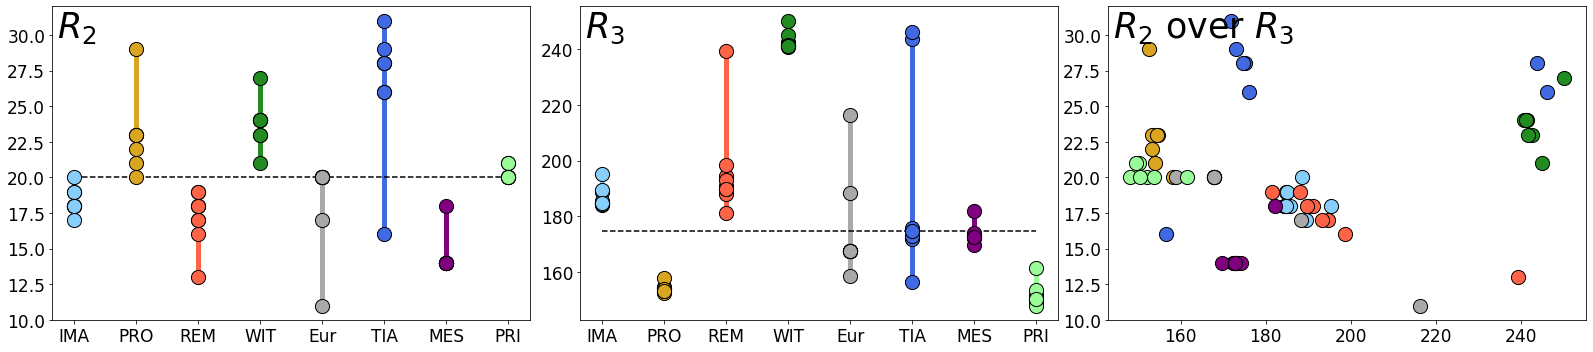

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5), facecolor='white')
for m_i, m in enumerate(all_models):
    if m == "IMAGE 3.2": lw = 5
    else: lw=5
    dat = XRe.S2_time.sel(Model=m, Scenario=c400lins)
    mi = m[:3]
    ax1.plot([mi]*len(dat), dat, c=ModelCols_touse[m_i], label=m, lw=lw)
    ax1.scatter([mi]*len(dat), dat, c=ModelCols_touse[m_i], s=200, lw=1, edgecolor='k', zorder=1e9)

    # s3mean = np.nanmean(XRe.S3_speedmax.sel(Model=m, Scenario=c400lins))
    # s3std = np.nanstd(XRe.S3_speedmax.sel(Model=m, Scenario=c400lins))
    dat2 = XRe.S3_speedmax.sel(Model=m, Scenario=c400lins)
    dat = dat[dat2 != 0]
    dat2 = dat2[dat2 != 0]
    if np.nanstd(dat2) != 0:
        ax2.plot([mi]*len(dat2), dat2, c=ModelCols_touse[m_i], label=m, lw=lw)
        ax2.scatter([mi]*len(dat2), dat2, c=ModelCols_touse[m_i], s=200, lw=1, edgecolor='k', zorder=1e9)

    #ax3.plot(dat2, dat, c=ModelCols_touse[m_i], label=m, lw=lw)
    ax3.scatter(dat2, dat, c=ModelCols_touse[m_i], s=200, lw=1, edgecolor='k', zorder=1e9, label=m)
    # ax3.plot([s3mean-s3std, s3mean, s3mean+s3std], [s2mean, s2mean, s2mean], c=ModelCols_touse[m_i], lw=lw)
    # ax3.scatter([s3mean-s3std, s3mean, s3mean+s3std], [s2mean, s2mean, s2mean], c=ModelCols_touse[m_i], s=90, lw=1, edgecolor='k', zorder=1e9)

mn = np.nanmedian(XRe.S2_time.sel(Model=all_models, Scenario=c400lins))
st = np.std(XRe.S2_time.sel(Model=all_models, Scenario=c400lins))
ax1.plot([m[:3] for m in all_models], [mn]*len(all_models), '--k')
mn = np.nanmedian(XRe.S3_speedmax.sel(Model=all_models, Scenario=c400lins))
st = np.std(XRe.S3_speedmax.sel(Model=all_models, Scenario=c400lins))
ax2.plot([m[:3] for m in all_models], [mn]*len(all_models), '--k')

for i in range(3):
    ax = [ax1, ax2, ax3][i]
    ax.text(0.01, 0.99, [r'$R_2$', r'$R_3$', r'$R_2$ over $R_3$'][i], transform=ax.transAxes, fontsize=35, ha='left', va='top', zorder=1e9)
    ax.tick_params(axis='both', which='major', labelsize=17)
    ax.tick_params(axis='both', which='minor', labelsize=17)

#plt.legend()
#ax1.set_title("S2")
#ax2.set_title("S3")
#ax3.set_title("S2 over S3")
fig.tight_layout()
plt.savefig("C:/Users/dekkerm/OneDrive - Planbureau voor de Leefomgeving/Documenten/Writing/2022 ECEMF Indicators/Figures/Figure_SI_s2vss3.png", dpi = 400, bbox_inches = "tight")
plt.savefig("C:/Users/dekkerm/OneDrive - Planbureau voor de Leefomgeving/Documenten/Writing/2022 ECEMF Indicators/Figures/Figure_SI_s2vss3.svg", bbox_inches = "tight")

S1 and S1s

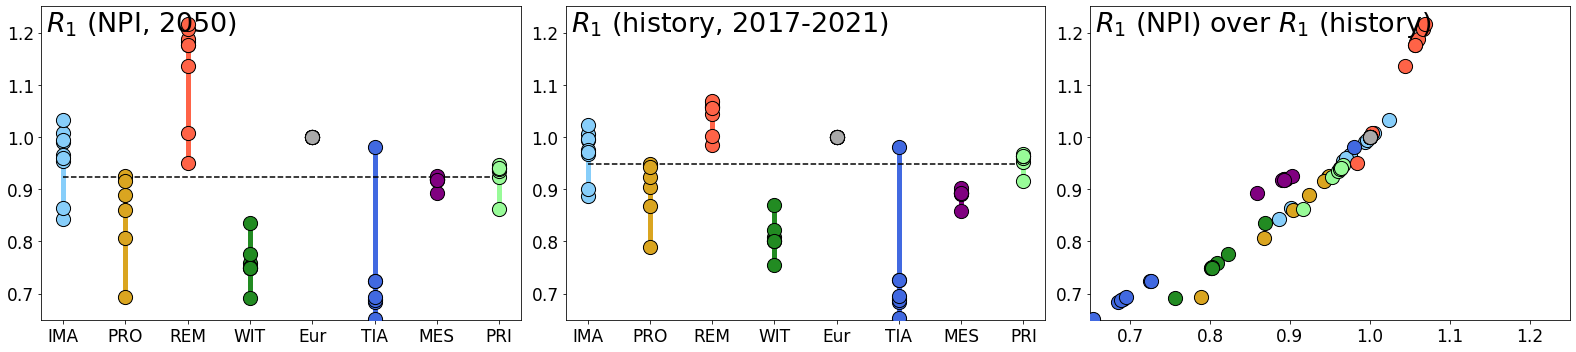

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5), facecolor='white')
for m_i, m in enumerate(all_models):
    if m == "IMAGE 3.2": lw = 5
    else: lw=5
    dat = XRe.S1_rai.sel(Model=m, Scenario=c400lins)
    mi = m[:3]
    ax1.plot([mi]*len(dat), dat, c=ModelCols_touse[m_i], label=m, lw=lw)
    ax1.scatter([mi]*len(dat), dat, c=ModelCols_touse[m_i], s=200, lw=1, edgecolor='k', zorder=1e9)

    # s3mean = np.nanmean(XRe.S3_speedmax.sel(Model=m, Scenario=c400lins))
    # s3std = np.nanstd(XRe.S3_speedmax.sel(Model=m, Scenario=c400lins))
    dat2 = XRe.S1s_rai.sel(Model=m, Scenario=c400lins)
    dat = dat[dat2 != 0]
    dat2 = dat2[dat2 != 0]
    if np.nanstd(dat2) != 0:
        ax2.plot([mi]*len(dat2), dat2, c=ModelCols_touse[m_i], label=m, lw=lw)
        ax2.scatter([mi]*len(dat2), dat2, c=ModelCols_touse[m_i], s=200, lw=1, edgecolor='k', zorder=1e9)

    #ax3.plot(dat2, dat, c=ModelCols_touse[m_i], label=m, lw=lw)
    ax3.scatter(dat2, dat, c=ModelCols_touse[m_i], s=200, lw=1, edgecolor='k', zorder=1e9, label=m)

    # ax3.plot([s3mean-s3std, s3mean, s3mean+s3std], [s2mean, s2mean, s2mean], c=ModelCols_touse[m_i], lw=lw)
    # ax3.scatter([s3mean-s3std, s3mean, s3mean+s3std], [s2mean, s2mean, s2mean], c=ModelCols_touse[m_i], s=90, lw=1, edgecolor='k', zorder=1e9)

mn = np.nanmedian(XRe.S1_rai.sel(Model=all_models, Scenario=c400lins))
st = np.std(XRe.S1_rai.sel(Model=all_models, Scenario=c400lins))
ax1.plot([m[:3] for m in all_models], [mn]*len(all_models), '--k')
mn = np.nanmedian(XRe.S1s_rai.sel(Model=all_models, Scenario=c400lins))
st = np.std(XRe.S1s_rai.sel(Model=all_models, Scenario=c400lins))
ax2.plot([m[:3] for m in all_models], [mn]*len(all_models), '--k')

for i in range(3):
    ax = [ax1, ax2, ax3][i]
    ax.text(0.01, 0.99, [r'$R_1$ (NPI, 2050)', r'$R_1$ (history, 2017-2021)', r'$R_1$ (NPI) over $R_1$ (history)'][i], transform=ax.transAxes, fontsize=27, ha='left', va='top', zorder=1e9)
    ax.tick_params(axis='both', which='major', labelsize=17)
    ax.tick_params(axis='both', which='minor', labelsize=17)
    ax.set_ylim([0.65, 1.25])
ax3.set_xlim([0.65, 1.25])

#plt.legend()
#ax1.set_title("S2")
#ax2.set_title("S3")
#ax3.set_title("S2 over S3")
fig.tight_layout()
plt.savefig("C:/Users/dekkerm/OneDrive - Planbureau voor de Leefomgeving/Documenten/Writing/2022 ECEMF Indicators/Figures/Figure_SI_s1vss1.png", dpi = 400, bbox_inches = "tight")
plt.savefig("C:/Users/dekkerm/OneDrive - Planbureau voor de Leefomgeving/Documenten/Writing/2022 ECEMF Indicators/Figures/Figure_SI_s1vss1.svg", bbox_inches = "tight")

In [35]:
s2 = np.array(XRe.sel(Model=Models_touse, Scenario=c400lins, Time=2050).S2_time).flatten()
s3 = np.array(XRe.sel(Model=Models_touse, Scenario=c400lins, Time=2050).S3_speedmax).flatten()

In [36]:
import numpy.ma as ma
print(ma.corrcoef(ma.masked_invalid(s2), ma.masked_invalid(s3)))

[[1.0 0.1489703052638412]
 [0.1489703052638412 1.0]]


NPIs and baselines

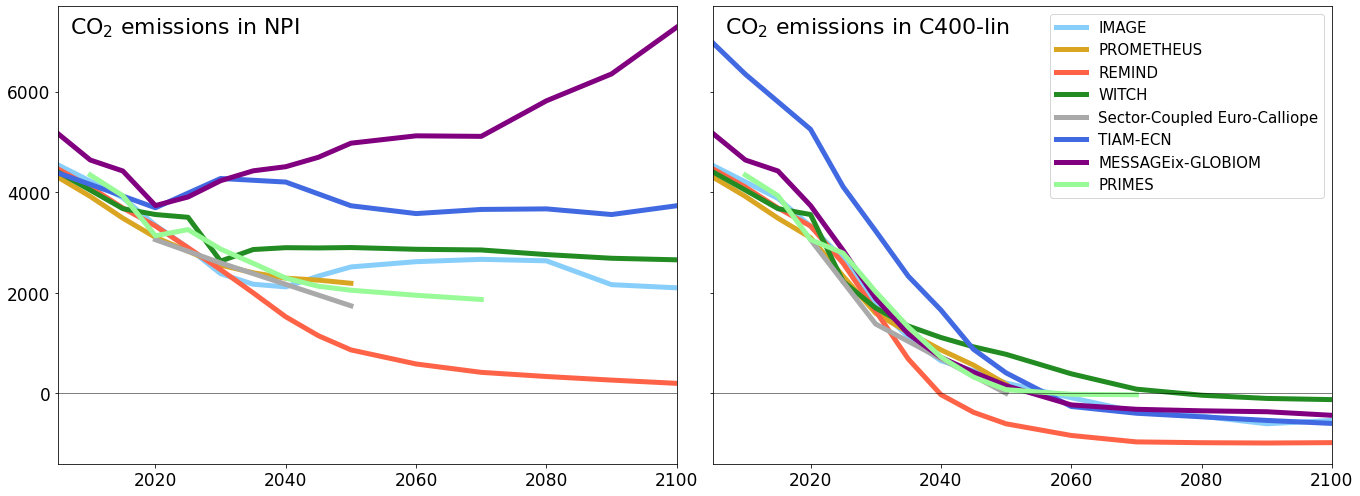

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 7), sharey=True, facecolor='white')
for m_i, m in enumerate(all_models):
    if m == "IMAGE 3.2": lw = 5
    else: lw=5
    y = ax1.plot(XRe.Time, XRe.sel(Scenario="DIAG-NPI", Model=m, Variable="Emissions|CO2").Value, c=ModelCols_touse[m_i], label=m.split(' ')[0], lw=lw)
    if m == "Euro-Calliope 2.0":
        mod = "Sector-Coupled Euro-Calliope"
        ax2.plot(XRe.Time, XRe.sel(Scenario="DIAG-C400-lin", Model=m, Variable="Emissions|CO2").Value, c=ModelCols_touse[m_i], label=mod, lw=lw)
    else:
        #ax1.plot(XRe.Time, XRe.sel(Scenario="DIAG-Base", Model=m, Variable="Emissions|CO2").Value, ':', c=y[0].get_color(), label=m, lw=lw)
        ax2.plot(XRe.Time, XRe.sel(Scenario="DIAG-C400-lin", Model=m, Variable="Emissions|CO2").Value, c=ModelCols_touse[m_i], label=m.split(' ')[0], lw=lw)
ax1.set_xlim([2005, 2100])
ax2.set_xlim([2005, 2100])
ax1.plot([-1e3, 1e4], [0, 0], 'k', lw=0.5)
ax2.plot([-1e3, 1e4], [0, 0], 'k', lw=0.5)
plt.legend(fontsize=15)
ax1.text(0.02, 0.98, r"CO$_2$ emissions in NPI", fontsize=22, transform=ax1.transAxes, va='top')
ax2.text(0.02, 0.98, r"CO$_2$ emissions in C400-lin", fontsize=22, transform=ax2.transAxes, va='top')
ax1.tick_params(axis='both', which='major', labelsize=17)
ax1.tick_params(axis='both', which='minor', labelsize=17)
ax2.tick_params(axis='both', which='major', labelsize=17)
ax2.tick_params(axis='both', which='minor', labelsize=17)
fig.tight_layout()
plt.savefig("C:/Users/dekkerm/OneDrive - Planbureau voor de Leefomgeving/Documenten/Writing/2022 ECEMF Indicators/Figures/Figure_SI_baseornpi.png", dpi = 400, bbox_inches = "tight")
plt.savefig("C:/Users/dekkerm/OneDrive - Planbureau voor de Leefomgeving/Documenten/Writing/2022 ECEMF Indicators/Figures/Figure_SI_baseornpi.svg", bbox_inches = "tight")

In [38]:
1-XRe.sel(Scenario="DIAG-NPI", Time=2050, Variable="Emissions|CO2").Value / XRe.sel(Scenario="DIAG-NPI", Time=2020, Variable="Emissions|CO2").Value

<xarray.DataArray 'Value' (Model: 8)>
array([ 0.43004421,  0.2480374 , -0.33215216,  0.34572249,  0.29462393,
        0.74045897, -0.01078318,  0.18458798])
Coordinates:
    Scenario  <U33 'DIAG-NPI'
    Variable  <U13 'Emissions|CO2'
  * Model     (Model) object 'Euro-Calliope 2.0' 'IMAGE 3.2' ... 'WITCH 5.1'

Text(0.5, 1.0, 'GDP|PPP in c400-lin minus that in limbio')

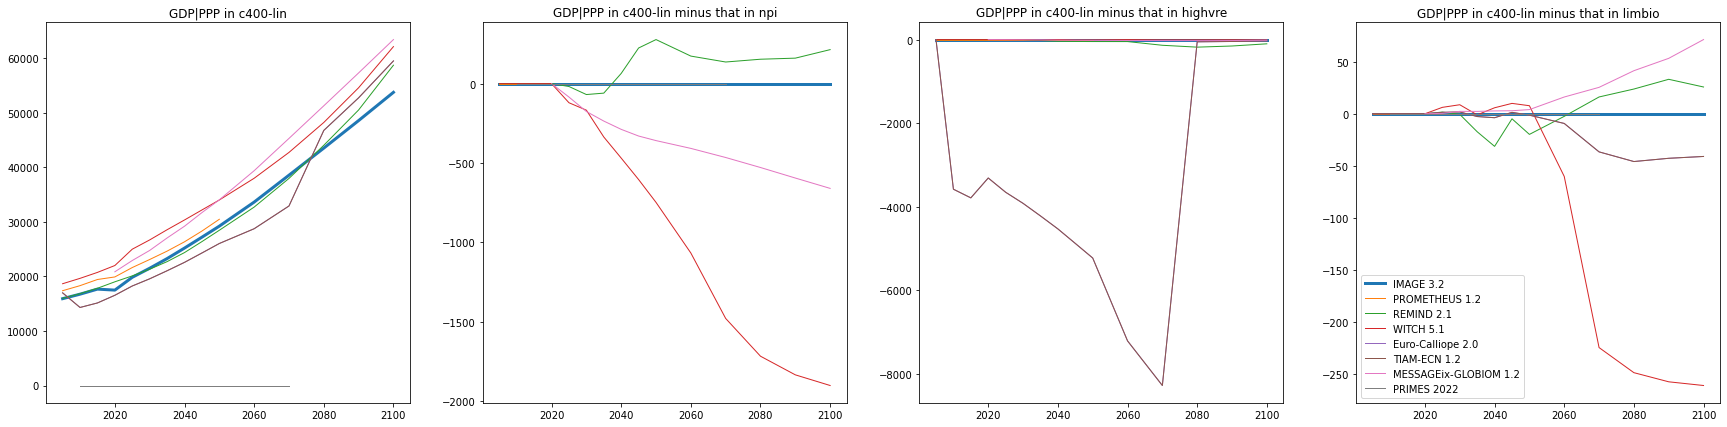

In [39]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 7))
for m in all_models:
    if m == "IMAGE 3.2": lw = 3
    else: lw=1
    ax1.plot(XRe.Time, XRe.sel(Scenario="DIAG-C400-lin", Model=m, Variable="GDP|PPP").Value, label=m, lw=lw)
    ax2.plot(XRe.Time, XRe.sel(Scenario="DIAG-C400-lin", Model=m, Variable="GDP|PPP").Value - XRe.sel(Scenario="DIAG-NPI", Model=m, Variable="GDP|PPP").Value, label=m, lw=lw)
    ax3.plot(XRe.Time, XRe.sel(Scenario="DIAG-C400-lin", Model=m, Variable="GDP|PPP").Value - XRe.sel(Scenario="DIAG-C400-lin-HighVRE", Model=m, Variable="GDP|PPP").Value, label=m, lw=lw)
    ax4.plot(XRe.Time, XRe.sel(Scenario="DIAG-C400-lin", Model=m, Variable="GDP|PPP").Value - XRe.sel(Scenario="DIAG-C400-lin-LimBio", Model=m, Variable="GDP|PPP").Value, label=m, lw=lw)
plt.legend()
ax1.set_title("GDP|PPP in c400-lin")
ax2.set_title("GDP|PPP in c400-lin minus that in npi")
ax3.set_title("GDP|PPP in c400-lin minus that in highvre")
ax4.set_title("GDP|PPP in c400-lin minus that in limbio")

(2020.0, 2100.0)

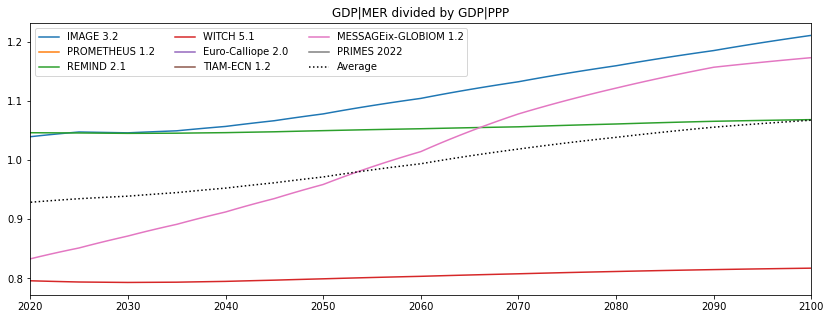

In [40]:
fig, ax = plt.subplots(figsize=(14,5))
dats = []
for m in all_models:
    dat = np.array(XRe.sel(Scenario="DIAG-C400-lin", Model=m, Variable="GDP|MER").Value/XRe.sel(Scenario="DIAG-C400-lin", Model=m, Variable="GDP|PPP").Value)
    dat[dat <0] = np.nan
    dat[dat > 1e5] = np.nan
    plt.plot(XRe.Time, dat, label=m)
    dats.append(dat)
plt.plot(XRe.Time, np.nanmean(np.array(dats), axis=0), 'k:', label="Average")
plt.legend(ncol=3)
plt.title("GDP|MER divided by GDP|PPP")
plt.xlim([2020, 2100])

Modality of indicators

In [41]:
names =[[r"$R_1$", r"$R_2$", r"$R_3$", r"$R_4$", r"$R_5$"],
        [r"$M_1$", r"$M_2$", r"$M_3$", r"$M_4$"],
        [r"$Es_1$", r"$Es_2$", r"$Es_3$", r"$Es_4$", r"$Es_5$", r"$Es_6$", r"$Es_7$"],
        [r"$Ed_1$", r"$Ed_2$", r"$Ed_3$",r"$Ed_4$", r"$Ed_5$"],
        [r"$C_1$", r"$C_2$", r"$C_3$"]]

namesf =[r"$R_1$", r"$R_2$", r"$R_3$", r"$R_4$", r"$R_5$",
        r"$M_1$", r"$M_2$", r"$M_3$", r"$M_4$",
        r"$Es_1$", r"$Es_2$", r"$Es_3$", r"$Es_4$", r"$Es_5$", r"$Es_6$", r"$Es_7$",
        r"$Ed_1$", r"$Ed_2$", r"$Ed_3$",r"$Ed_4$", r"$Ed_5$",
        r"$C_1$", r"$C_2$", r"$C_3$"]

vars = ["S1_rai", "S2_time", "S3_speedmax", "S4_sensprim", "S5_sensdem",
        "M1_cir", "M2_eir", "M3_cc", "M4_nonco2",
        "ES1_coal", "ES2_oil", "ES3_gas", "ES4_solar", "ES5_wind", "ES6_biomass", "ES7_nuclear",
        "ED1_etrans", "ED2_eindus", "ED3_ebuild", "ED4_emise", "ED5_hydrogen",
        "C1_cost", "C2_ti", "C3_dem"]

namesfull = ["Relative abatement index", "Time scale of initial mitigation", "Maximum mitigation speed", "Sensitivity primary energy mix", "Sensitivity demand",
"Carbon intensity reduction", "Energy intensity reduction", "Carbon capture", r"Role of non-CO$_2$"+"abatement",
"Coal", "Oil", "Gas", "Solar", "Wind", "Biomass", "Nuclear",
"Electricity transport", "Electricity industry", "Electricity buildings", "Electricity emissions", "Hydrogen use",
"Cumulative costs per abatement value", "Transformation index", "Demand shifts"]

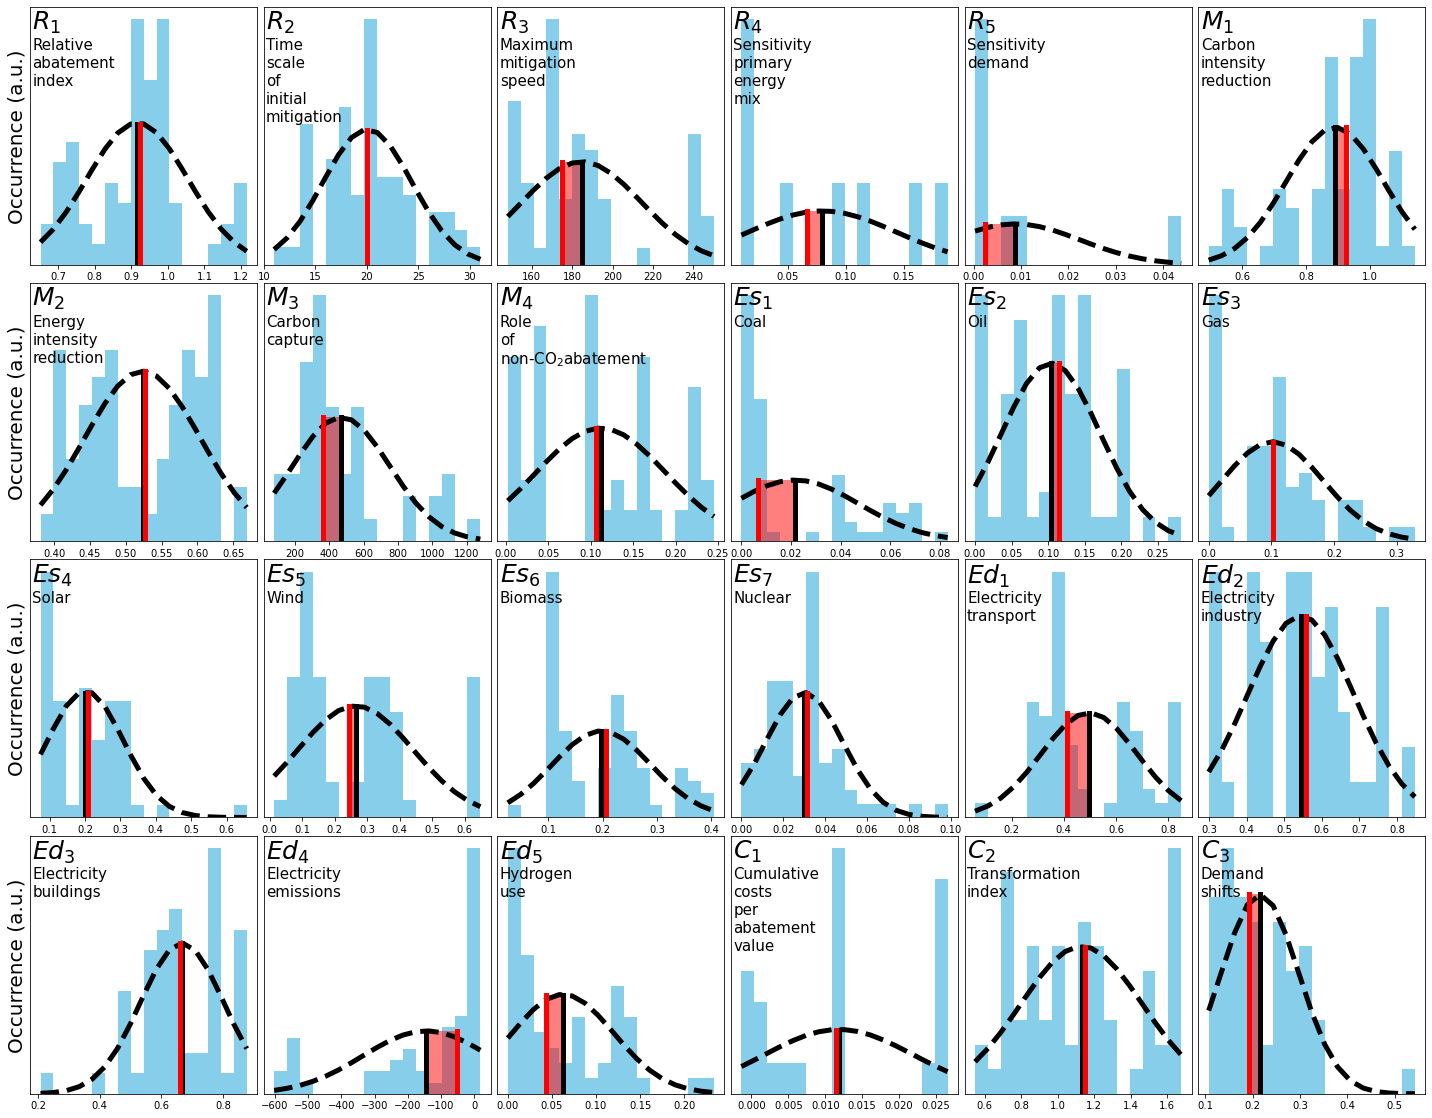

In [42]:
from scipy.stats import norm
import matplotlib.mlab as mlab

fig, ((ax1, ax2, ax3, ax4, ax5, ax6), (ax7, ax8, ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16, ax17, ax18), (ax19, ax20, ax21, ax22, ax23, ax24)) = plt.subplots(4, 6, figsize=(25, 20), facecolor='white')
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20, ax21, ax22, ax23, ax24]

for i in range(24):
    ax = axes[i]
    data = np.array(XRe.sel(Time=2050, Scenario=c400lins)[vars[i]]).flatten()
    data = data[~np.isnan(data)]
    (mu, sigma) = norm.fit(data)
    n, bins, patches = ax.hist(data, 16, lw=lw, facecolor='skyblue')
    ax.text(0.01, 0.99, namesf[i], transform=ax.transAxes, ha='left', va='top', fontsize=25)
    fullname = namesfull[i].split(' ')
    for f_i, f in enumerate(fullname):
        ax.text(0.01, 0.88-f_i*0.07, f, transform=ax.transAxes, ha='left', va='top', fontsize=15)
    
    y = norm.pdf( bins, mu, sigma)
    l = ax.plot(bins, y*len(data)/np.sum(y), 'k--', linewidth=5)
    ax.set_yticks([])
    ax.set_ylim(ax.get_ylim())
    mx = np.max(y*len(data)/np.sum(y))
    ax.plot([mu, mu], [-1e3, mx], 'k', linewidth=5)
    ax.plot([np.median(data), np.median(data)], [-1e3, mx], 'red', linewidth=5)
    x = [np.median(data), mu]
    y1 = np.array([0, 0])
    y2 = np.array([mx, mx])
    ax.fill_between(x, y1, y2, where=y2>=y1, facecolor='red', alpha=0.5)

for i in [0, 6, 12, 18]:
    ax = axes[i]
    ax.set_ylabel("Occurrence (a.u.)", fontsize=20)
fig.subplots_adjust(wspace=0.03, hspace=0.07)
plt.savefig("C:/Users/dekkerm/OneDrive - Planbureau voor de Leefomgeving/Documenten/Writing/2022 ECEMF Indicators/Figures/Figure_SI_meanormedian.png", dpi = 400, bbox_inches = "tight")
plt.savefig("C:/Users/dekkerm/OneDrive - Planbureau voor de Leefomgeving/Documenten/Writing/2022 ECEMF Indicators/Figures/Figure_SI_meanormedian.svg", bbox_inches = "tight")